In [2]:
# a few packages we need to import

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 

import itertools

# Exercise 1 - REINFORCE

The goal of this exercise is to implement the simplest policy gradient algorith, REINFORCE, and then augment it with a baseline coming from an approximation of the value function. We will use this algorithm on the inverted pendulum model. The class below defines the pendulum model and some helper function to simulate it.

In [3]:
class Pendulum:
    """
    This class describes an inverted pendulum and provides some helper functions
    """
    
    def __init__(self):
        """
        constructor of the class
        """
        #gravity constant
        self.g=9.81
        
        # number of dimensions (angle and angular velocity)
        self.num_states = 2
        
        # the available control inputs
        self.controls = np.array([-5., 0., 5.])
        self.nb_controls = len(self.controls)

        # the maximum velocity
        self.vmax = 6.
        # the range of allowable states
        self.state_range = np.array([[0, 2*np.pi],[-self.vmax, self.vmax]])

        #simulation step
        self.delta_t = 0.1
        # internal integration step
        self._internaldt = 0.01
        self._integration_ratio = int(round(self.delta_t / self._internaldt))
        
            
    def step(self,x,u):
        """
        This function integrates the pendulum for one step of self.delta_t seconds
        
        Inputs:
        x: state of the pendulum (x,v) as a 2D numpy array
        u: control as a scalar
        
        Output:
        the state of the pendulum as a 2D numpy array at the end of the integration
        """
        x_next = x[0]
        v_next = x[1]
        for i in range(self._integration_ratio):
            x_next = (x_next + self._internaldt * v_next)%(2*np.pi)
            v_next = np.clip(v_next + self._internaldt * (u-self.g*np.sin(x_next)), -self.vmax, self.vmax)
        return np.array([x_next,v_next])
    
    def simulate(self, x0, policy, T):
        """
        This function simulates the pendulum for T seconds from initial state x0 using a policy
        (policy is called as policy(x) and returns one control)
        
        Inputs:
        x0: the initial conditions of the pendulum as a 2D array (angle and velocity)
        T: the time to integrate for
        
        Output:
        x (2D array) and u (1D array) containing the time evolution of states and control
        """
        horizon_length = int(T/self.delta_t)
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([horizon_length])
        for i in range(horizon_length):
            u[i] = policy(x[:,i])
            x[:,i+1] = self.step(x[:,i], u[i])
        return x, u

In [4]:
def animate_pendulum(x, dt):
    """
    This function makes an animation showing the behavior of the pendulum
    takes as input the result of a simulation - dt is the sampling time (0.1s normally)
    """
    
    # here we check if we need to down-sample the data for display
    #downsampling (we want 100ms DT or higher)
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    plotx = x[:,::steps]
    
    fig = matplotlib.figure.Figure(figsize=[6,6])
    matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-1.3,1.3], ylim=[-1.3,1.3])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'o', lw=2)
    list_of_lines.append(line)
    
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_pend = np.sin(plotx[0,i])
        y_pend = -np.cos(plotx[0,i])
        
        list_of_lines[0].set_data([0., x_pend], [0., y_pend])
        list_of_lines[1].set_data([x_pend, x_pend], [y_pend, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

This function can be used to plot the results of a simulation of the pendulum

In [5]:
def plot_results(pend, val, pol, policy, animate=True):
    """
    This function plots the results. It displays the value function, the policy for all states.
    Then it integrates the pendulum from state [0,0] and displays the states and control as a function of time
    Finally it shows an animation of the result
    """
    x0 = np.array([0.,0.])

    x, u = pend.simulate(x0, policy, 10)

    plt.figure(figsize=[6,6])
    plt.imshow(val, extent=[0., 2*np.pi, -6, 6], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Value Function')

    plt.figure(figsize=[6,6])
    plt.imshow(pol, extent=[0., 2*np.pi, -6, 6], aspect='auto')
    plt.xlabel('Pendulum Angle')
    plt.ylabel('Velocity')
    plt.title('Policy')

    time = np.linspace(0.,20., len(x[0,:]))
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(time,x[0,:])
    plt.ylabel('angle')
    plt.subplot(3,1,2)
    plt.plot(time,x[1,:])
    plt.ylabel('velocity')
    plt.subplot(3,1,3)
    plt.plot(time[:-1],u)
    plt.ylabel('control')
    if animate:
        animate_pendulum(x, pend.delta_t)

## Reinforcement learning problem

We would like to get the pendulum upright starting from the down rest position. It has two states, its angle $\theta$ (where $\theta=0$ means that the pendulum is down) and its angular velocity $\omega$. The state of the system is $x = [\theta^T \omega^T]^T$. We also assume that we have only 3 possible control inputs $[-5, 0, 5]$.

We formulate this problem as a finite horizon problem where we want to minimize the cost
$$\min \sum_{i=0}^{N} \alpha^i g(\theta_i, \omega_i, u_i)$$
where the instantaneous cost is $$g(x,v,u) = (x-\pi)^2 + 0.01 v^2 + 0.00001 u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls

## Stochastic policies

We will use stochastic policies $\pi(u | x,\theta_\pi)$ that are parametrized by $\theta_\pi$ (i.e. the parameters to learn). We will use exponential softmax distributions $$\pi(u|x,\theta) = \frac{e^{h(x,u,\theta_\pi)}}{\sum_a e^{h(x,a,\theta)}}$$ where in the denominator we sum over the 3 possible controls.
The function $h(x,u,\theta_\pi)$ is a function which reflects the preference of a control for a given state. We will use a linear combination of nonlinear basis functions to define it as
$$h(x,u,\theta_\pi) = \theta_\pi^T \Psi(x,u)$$
where $$\Psi(x,u) = [\psi_0(x,u), \cdots, \psi_m(x,u)]^T$$ is a vector of $m$ nonlinear basis functions.
In our exercise, we use periodic basis functions. For a given order $p$, we define $m = 6 (p+1)^2$ basis functions as
$$\psi_{k,l,c,0}(\theta,\omega,u) = \frac{\mathrm{e}^{-\frac{(u-u_c)^2}{0.002}}}{\sqrt{2\pi 0.001}} \cos(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$
and
$$\psi_{k,l,c,1}(\theta,\omega,u) = \frac{\mathrm{e}^{-\frac{(u-u_c)^2}{0.002}}}{\sqrt{2\pi 0.001}} \sin(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$
where $0\leq k \leq p$ and $0 \leq l \leq p$ are integers, $u_c$ is the control indexes by $c$ (i.e. it is either -5, 0 or 5) and $\omega_{max}$ is the maximum velocity of the pendulum (in order to get one period over the full range of $\omega$). Note that $\theta$ already ranges from $0$ to $2\pi$.

The class below defines these stochastic policies as well as helper functions to sample from the policy, get the vector of basis functions and get the probability distribution $\pi(.|x,\theta_\pi)$

In [6]:
class StochasticPolicyPeriodicFeatures:
    """
    This class implements a stochastic policy with linear sum of nonlinear features
    the features are periodic functions multiplied by a radial basis function of u
    """
    def __init__(self, controls, order = 2):
        """
        class constructor - controls is the array of control inputs, order is the order of the periodic basis
        """
        self.controls =  controls.copy()
        self.num_controls = len(self.controls)
        self.exp_basis = np.zeros([self.num_controls])
        self.order = order
        
        # the vector of basis functions
        self.basis_vector = np.zeros([2*self.num_controls*(self.order+1)**2])
        
        # the linear parameters to learn
        self.theta = np.zeros_like(self.basis_vector)
        
    def basis(self, x, u):
        """
        Returns the vector of basis functions evaluated at x,u
        """
        dx = x[0]
        dy = x[1]/6. * np.pi
        count = 0
        for c in self.controls:
            du = 1/(np.sqrt(2*np.pi*0.001)) * np.exp(-(u-c)**2/0.002)
            for j,k in itertools.product(range(self.order+1), range(self.order+1)):
                self.basis_vector[count] = du * np.cos(j*dx + k*dy)
                self.basis_vector[count+1] = du * np.sin(j*dx + k*dy)
                count += 2
        return self.basis_vector

    def get_distribution(self, x):
        """ 
        Computes pi(u|x) for all u 
        returns an array of pi and an array of basis functions (row is the control index and column is the )
        """
        dist = np.zeros_like(self.controls)
        basis_fun = np.zeros([len(self.theta), len(self.controls)])
        for i,u in enumerate(self.controls):
            # this gives the basis function evaluated as (x,u)
            basis_fun[:,i] = self.basis(x,u)
            # dist gives exp(theta * basis_function)
            dist[i] = np.exp(self.theta.dot(basis_fun[:,i]))

        # we sum the exponentials
        sm = np.sum(dist)
        # dist is rescaled by the sum of exponentials (we now have a probability distribution)
        dist = dist/sm
        return dist, basis_fun
    
    def sample(self, x):
        """
        sample from the stochastic policy given x
        it returns the index of the control and its value
        """
        probs, basis = self.get_distribution(x)
        index = np.random.choice(len(self.controls), p=probs)
        return index, self.controls[index]

## Value function approximation

We also use a function approximator for the value function (used for the REINFORCE algorithm with baseline). We will write our approximation of the value function as
$$V(x,\theta_V) = \theta_V^T B(x)$$
where the vector of basis functions $B$ is also constituted of periodic functions of the form
$$b_{k,l,0}(\theta,\omega) = \cos(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$ and
$$b_{k,l,1}(\theta,\omega) = \sin(k \theta + l \frac{\pi}{\omega_{max}}\omega)$$

The class below implements such a value function approximation

In [7]:
class ValueFunctionPeriodicFeatures:
    """
    This class implements a function approximator with linear sum of nonlinear features
    the features are periodic functions
    We use this to approximate the value function
    """
    
    def __init__(self, order = 2):
        """
        the class constructor - order is the order of the periodic basis
        """
        
        self.order = order
        self.basis_vector = np.zeros([2*(self.order+1)**2])

        # the parameters to learn
        self.theta = np.zeros_like(self.basis_vector)
        
    def basis(self, x):
        """
        Returns the vector of basis functions evaluated at x
        """
        dx = x[0]
        dy = x[1]/6. * np.pi
        count = 0
        for j,k in itertools.product(range(self.order+1), range(self.order+1)):
            self.basis_vector[count] = np.cos(j*dx + k*dy)
            self.basis_vector[count+1] = np.sin(j*dx + k*dy)
            count += 2
        return self.basis_vector
    
    def getValue(self, x):
        """
        returns the value at x and the basis functions evaluated at x
        """
        bs = self.basis(x)
        return bs.dot(self.theta), bs

## REINFORCE

We want to implement the REINFORCE algorithm (where an iteration is shown below):
1. Generate an episode $x_0, u_0, x_1, u_1, \cdots, x_N, u_N$, where $u_i$ is sampled from the current policy $\pi(-|x,\theta_\pi)$
2. For each step $t$ of the episode
 * compute the return G_t = \sum{k=t}^T \alpha^{k-t}g(x_k, u_k)
 * do gradient descent on the policy parameters $\theta_\pi \leftarrow \theta_\pi - \gamma_\pi \alpha^t G_t \nabla \ln \pi(u_t | x_t, \theta_\pi)$
 
where $\gamma_\pi$ is a learning rate
 
 ## REINFORCE with baseline
 
 The REINFORCE with baseline algorithm, in addition, maintains an estimate of the value function. One iteration is
 1. Generate an episode $x_0, u_0, x_1, u_1, \cdots, x_N, u_N$, where $u_i$ is sampled from the current policy $\pi(-|x,\theta_\pi)$
 2. For each step $t$ of the episode
 * compute the return G_t = \sum{k=t}^T \alpha^{k-t}g(x_k, u_k)
 * \delta_t = G_t - V(x_t, \theta_V)
 * do gradient ascent on the value parameters $\theta_V \leftarrow \theta_V + \gamma_V \alpha^t \delta_t \nabla V(x_t, \theta_V)$
 * do gradient descent on the policy parameters $\theta_\pi \leftarrow \theta_\pi - \gamma_\pi \alpha^t \delta_t \nabla \ln \pi(u_t | x_t, \theta_\pi)$
 
where $\gamma_\pi$ and $\gamma_V$ are learning rates

## Questions

a) Compute $\nabla V(x, \theta_V)$ with respect to $\theta_V$ for a generic function $ V(x, \theta_V) = \theta_V^T B(x)$

b) Compute $\nabla \ln \pi(u_t | x_t, \theta_\pi)$ with respect to $\theta_\pi$ for a stochastic policy parametrized as $\pi(u|x,\theta) = \frac{e^{h(x,u,\theta_\pi)}}{\sum_a e^{h(x,a,\theta)}}$, with $h(x,u,\theta_\pi) = \theta_\pi^T \Psi(x,u)$

c) using the previous computations, the classes above (optional) and code skeleton below (also optional), implement the REINFORCE algorithm for the inverted pendulum. Use $\alpha = 0.99$, an episode length of 100 (i.e. 10 seconds) and order p=2 for the policy approximation. Hint: you may want to choose a learning rate between $10^{-8}$ and $10^{-11}$. How many episodes does it take to converge? Can the resulting policy (which is stochastic) balance the pendulum appropriately? (note you may want to test several times due to the stochasticity). Plot the learning progress (costs versus episodes), you may also want to use a moving average over the costs to remove noise.

d) implement the REINFORCE algorithm with baseline and answer the same questions as in c) (also use an order p=2 for the value function approximation). Additionally, plot the value function. Hint: you may want to choose a learning rate between $10^{-6}$ and $10^{-9}$ for updating the policy and a learning rate between $10^{-1}$ and $10^{-3}$ to update the value function.

e) Compare the convergence rate of both algorithms. Which one seem to be easier to use?

You can use the code skeleton below to answer the questions

In [8]:
class Reinforce:
    """
    An implementation of the reinforce algorithm (with or without baseline)
    """
    
    def __init__(self, model, cost, policy, discount_factor=0.99, 
                 episode_length=100, policy_learning_rate = 0.000001):
        """
        the class constructor
        """
        self.model = model
        self.cost = cost

        self.policy = policy
        
        self.discount_factor = discount_factor
        self.episode_length = episode_length
        
        self.policy_learning_rate = policy_learning_rate
            
    def iterate(self, num_iter=1):          
        """
        the main loop
        """
        learning_progress = []
        
        # here we allocate some useful vectors
        x_traj = np.zeros([self.episode_length+1, self.model.num_states])
        u_traj = np.zeros([self.episode_length, 1])
        u_index = np.zeros([self.episode_length], dtype=np.int)
        cost_traj = np.zeros([self.episode_length])
        
        for i in range(num_iter):  
            # generate an episode - start from 0
            x_traj[0,:] = np.zeros([2])
            # TO COMPLETE #
            # you can use the step function of self.model (i.e. the pendulum) to get the next state
            
            # now compute the returns Gt and update the policy parameters self.policy.theta through gradient descent
            # TO COMPLETE #

            # here we store the return at t=0 to get the learning progress
#             learning_progress.append(G)
                
        return learning_progress
            
    def get_Policy(self):
        """
        This helper function generate a 50x50 grid (theta x omega) with a policy (for display)
        the policy is computed as the expected control from pi
        we also compute a value function (to be used for the baseline part) - for now it is 0
        """
        n_discrete = 50
        pol = np.zeros([n_discrete,n_discrete])
        val = np.zeros([n_discrete,n_discrete])
        x_range = np.linspace(self.model.state_range[0,0], self.model.state_range[0,1], n_discrete)
        v_range = np.linspace(self.model.state_range[1,0], self.model.state_range[1,1], n_discrete)
        
        for i, x in enumerate(x_range):
            for j,v in enumerate(v_range):
                dist, basis = self.policy.get_distribution(np.array([x,v]))
                pol[i,j] = dist.dot(self.model.controls)
                # this can be used later to get a value estimate
                # val[i,j] = self.value.getValue(np.array([x,v]))[0] 
        return pol, val

def cost(x,u):
    """
    the cost function for the inverted pendulum
    """
    return (x[0] - np.pi)**2 + 0.01*x[1]**2 + 0.0001*u

In [9]:
# here we create all the objects
pendulum = Pendulum()
policy = StochasticPolicyPeriodicFeatures(controls = pendulum.controls, order = 2)
# to be used for the baseline
# value = ValueFunctionPeriodicFeatures(order = 2)
reinforce = Reinforce(pendulum, cost, policy, episode_length=100, 
                      discount_factor=0.99, policy_learning_rate = 0.00000001)

<IPython.core.display.Javascript object>


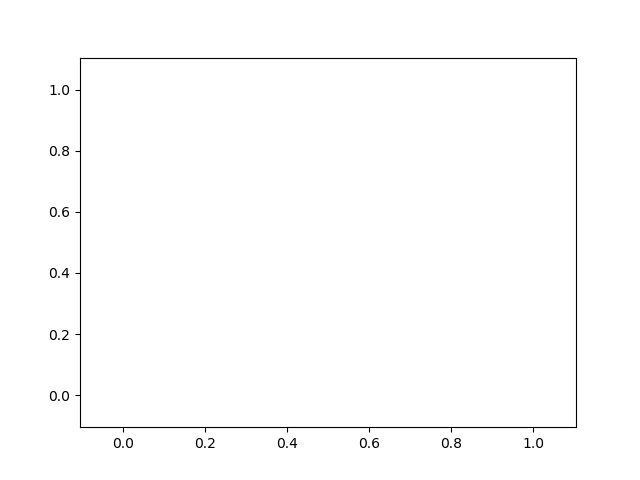

<IPython.core.display.Javascript object>


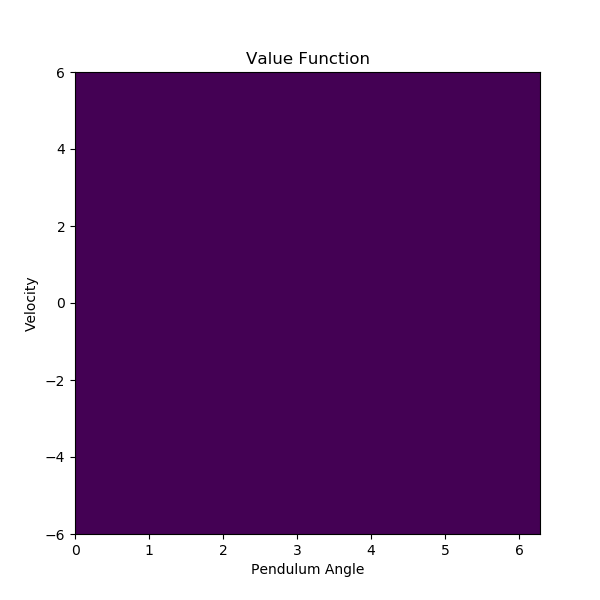

<IPython.core.display.Javascript object>


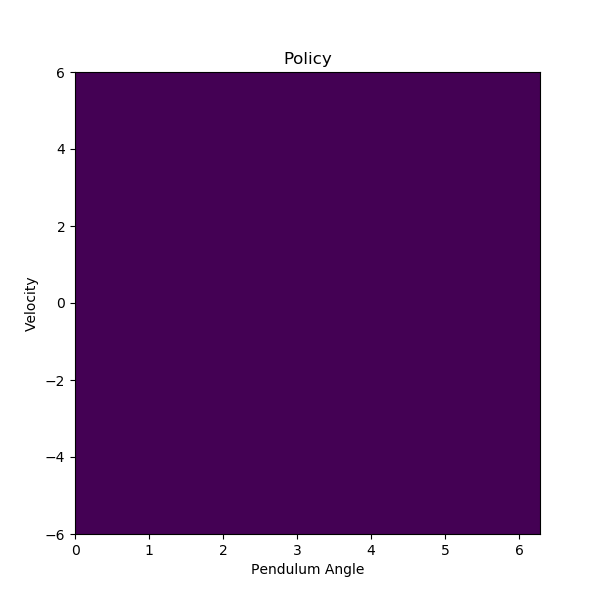

<IPython.core.display.Javascript object>


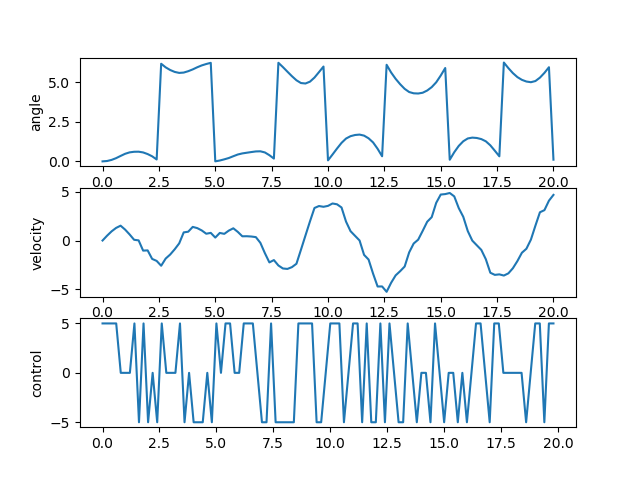

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAA0CJtZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1OSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMTkgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADRZliIQAEP/+94G/Mstf
IrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsADpCLH/2+kONwAT9lg/NYj
L/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2fy1TN9QNLS2doYg16nA3K
BIICjrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17mhCeWbA7zyXROB8c1qwBw
G6mF4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr15+LI/6q7q3wu/lDZN9tIlT
OzRJ5hxurCa6TP3YdJ0Pua9/TkOnB1BZtIQdZE2NNeG6ZBWKX2qe8riq2xS9wgxfOhJNJt6YhrXM
m7zjVbb5XjgbkHcxnQGuWAediwJYqi3fm4ujHJ0imNhaD37uUGnV0uhFHwdHqWMHnkkZYv5dDA2w
u6b3OQ9KRwn5X82CXdBrwTfk3PfgmQi7fk9RABc2Y/lr+wk7/NGHIW6xbWrCQjWI3kMgmnZdCoBs
9vyRLBTpCVIj7av8Cn5DSXlEn/Sd+3NrATU5DNYJFIv98ZA73iur1uVp0nGsXxBFlJ1H2+4c5v0s
c6J3GHQJ+QWfXMMMpnrGfqYO8ABZaLotsFB/LHkbFwuip7F+yFSJmOPjnv2p6EsCzZ4ktjM8W1dX
aEG2suS0/qszjbFQY02+AIr2VatguHCCKtVW5rTdr3RC+nngusn5+8GIXeecAAAEsMFHKmmOQJL6
c6omG4FzLrFROVCN8Y3SWZfWBnhVC5ZxYKdUzuUti4r9eKJYkh5hIAX8r4CVBmPr4lxft7JTFFDb
4zeNw275cj37UJqLVKDZmeogtLvAt6z/lAJSHOV1EvDoyLoAP/TaMlZg4J8C/rixrfyp386RIyEz
zaB4qRqHW3r4yV899BeqwpvFeYwF6ZH6yFH7NaPMHv608mcK/rb+N3V+ZjVHroxNPohGLqpoqBBi
gVWwJB7a9F9V0pIcGQjpc/4IhyKOd2GB4kyevIvqDyI8tb2VfNurZd/iJRFFazngO/7J1fS+2eXa
UlsoGi2IN8Vz/n/+OGjTci0T5kTPMcKzYGLrhUWxSjN3LS3xEX7+ixv2Nm20Fp2bNx8RothR9RwM
kC+l35YYwuA4d0sZ+ZCJRYd/a1HS2eCZoNViqysr+BKof5uSX8oWU8sthZLUL2GSa9etyWRPBtcb
lR6+jz9jz6cKF6ntihI0oWAowcnJ3Tz9v7as/byjiZJ1k1l3WDsK2GzNUh5GlNd5bgcwh3XdE5dL
RkyQbFUSW4xYyxYzdBNXgeaifK7NXFDwDWIGM5xJbC9CA791Mw6XYIbRpfDwMwoxWRtWjEt/mzau
duevt5P1RNFG/i/AiohKJSAOb4jZiP0mYH9sdmegdRoahaU63uNp0DOEH8DB8nv5Hm/hnAs0R0zF
MNR1rdZtUCZlBWCMP/C8d1juxMNN4y3sudgzpXH9QMEJE0GtBqZuh6KbGqqvkJeNrYfn3ElqN8Ua
pKONvyPs6xp7SBQIH7I0DAjyOrfm2DxBo8OU4etgBiwU21Onns6pxJsNUeZttlANczuqTWbs70fm
P+DEA1Sr/AbClbM439t/6VIeKDceG9+GHA2P2MwHkuoNzCSIp1PIQggSXGifY4XzTeNec+0QdrDe
OQACaha1q7r9XUENteKsGKJgo5Ju91miPVdABh9Zdw3bDJ3yPEaAsRwg7Iv4sopGT/01LIKw0JXr
4hg/JyxRr+JJzFS2U7XZ26no6PYNbdHv6NwbheSLkoF8n2eQ1yUjI0+eoNaZUUcSfDIN9rya3dEc
Tl/bvRAave5RyVTyBPLf/OlZzE5kjMdBetdhXIKTepb/6fG4p97xeFTVe1Mq6RIGtYoIdnpd1Mzw
HnurHSbVpdSn3T7abUFd6qisXV29k6uE/td51VOoLmS3n0upXazMtYr3V7yrQ+mMC8ttH8Bp1tvY
tga/UzWhJHPk9G57bC/pRycquKtb4BWKFjqxFj22fSEX1LRuTn61py3fwkWkHlRuzi1kBMpF1wAm
E+V/bRbnCFYoDQashkxLamCw4TmtrE4LtAFgqztPfu+3TYq22/ApodNkZoXyboD47Rl2Wzf7FhOw
DVnX3ZV4X5LMXKe540qcBfnOqn19C+rzrSWLr2ZL9n9HH58PMiPm52ZkUMkwerHn3941qDDHq0EX
g6eNUNmYeV2ARvQbX6Msv/a4UqmNqnE96fm8SV8dvhTQrIC/d9EK9Ax96CzmxuIjSgKSTb3GTdcN
Wa7Ua8zE7OKaEZPyjkLgraIOCXT5/6zcHnwYhNQtIciscvf2/ITkG6UwC/afxK6qrB4AXJH0BrOw
K5BA1E1Ktv6XDDPZp+ogexw4MSU/UzCxCLmwSjGAABY5iH7AxZl7ADKr2CJHbKAAAAMAAAMAAAMA
AClc07k+TG5Tl9DFrRngvpUoeQ4RezLul6z+piKAYtIEatKhBhOWHpBPULd7MWFCOlc1e8GEBL7G
mgf6ctnVmpKDzzsOMTqz0NZ7j8K9MqJbcFtMWcdFlZtG2YBaG7uqfkTs2X+M6OzbtI3QPp8SsAH/
MMQUMC5fU9qryjqaN8qwK5xhMdIMX2lk7njWPCJ2+To1wH7ewXfJ3a3mcK7tPNBq7rIYJlzPCNpQ
OGQdxsDa7ru9yVfj3zbAuPPckIEEhJEHVMdrHMQ8Rt+NVl1bZiZy44rzfknQR2LWFUh5RLqwkVMm
D5NEOSI//uI0fDUYuWZb4z9PvJ2ikbLhOu+MAHu2+QjDms1HeoNI62JYmmKxOQzGs5P7/7M2lJPn
bvtYoP8f+BYWGg08hvHZnXYYBNIMzMh5UE2dnkBGdfE4g/E9C0JdRmLths1xBISsfM6pb+DlXGmx
vAVlKC5SaV5P+N7VQ5ee0

In [10]:
# here we learn doing 300 episodes
lear = reinforce.iterate(300) #you will likely need more than 300 episodes!

# we plot the learning progress - also including a moving average (over 20 data points)
plt.figure()
plt.plot(lear)
ret = np.cumsum(lear)
win_avg = 20
ret[win_avg:] = ret[win_avg:] - ret[:-win_avg]
plt.plot(ret[win_avg - 1:] / win_avg)

# we get the policy/value as arrays
pol, val = reinforce.get_Policy()
# we create a controller using the policy to be used in the simulation
control_policy = lambda x : reinforce.policy.sample(x)[1]
# we plot results including a 10s simulation of the pendulum using the policy
plot_results(pendulum, val, pol, control_policy, animate=True)

In [19]:
#part A 
def gardient_v(X):
    return(X)

In [20]:
# part B
def gradient_p(index,prob_dist,func):
    term = [0]
    for i in range(func.shape[1]):
        term = term + (prob_dist[i]) * (func[:,i])
    grad = func[:,index] - term
    return grad

In [21]:
# part C
class Reinforce:
    """
    An implementation of the reinforce algorithm (with or without baseline)
    """
    
    def __init__(self, model, cost, policy, discount_factor=0.99, 
                 episode_length=100, policy_learning_rate = 0.000001):
        """
        the class constructor
        """
        self.model = model
        self.cost = cost

        self.policy = policy
        
        self.discount_factor = discount_factor
        self.episode_length = episode_length
        
        self.policy_learning_rate = policy_learning_rate
            
    def iterate(self, num_iter=1):          
        """
        the main loop
        """
        learning_progress = []
        
        # here we allocate some useful vectors
        x_traj = np.zeros([self.episode_length+1, self.model.num_states])
        u_traj = np.zeros([self.episode_length, 1])
        u_index = np.zeros([self.episode_length], dtype=np.int)
        cost_traj = np.zeros([self.episode_length])
        
        for i in range(num_iter):  

            x_traj[0,:] = np.zeros([2])
            for k in range(self.episode_length):
                u_index[k],u_traj[k] = self.policy.sample(x_traj[k,:])
                x_traj[k+1,:] = self.model.step(x_traj[k,:],u_traj[k]).transpose()
            for j in range(self.episode_length):
                G_t = 0
                for k in range(j,self.episode_length):
                    G_t = G_t + (self.discount_factor**(k-j))*cost(x_traj[k,:],u_traj[k])
                prob_dist,func = self.policy.get_distribution(x_traj[j,:])
                self.policy.theta =  self.policy.theta - self.policy_learning_rate*(self.discount_factor**j)*G_t*gradient_p(u_index[j],prob_dist,func)
            learning_progress.append(G_t)
        return learning_progress
        return(learning_progress)
            
    def get_Policy(self):
        """
        This helper function generate a 50x50 grid (theta x omega) with a policy (for display)
        the policy is computed as the expected control from pi
        we also compute a value function (to be used for the baseline part) - for now it is 0
        """
        n_discrete = 50
        pol = np.zeros([n_discrete,n_discrete])
        val = np.zeros([n_discrete,n_discrete])
        x_range = np.linspace(self.model.state_range[0,0], self.model.state_range[0,1], n_discrete)
        v_range = np.linspace(self.model.state_range[1,0], self.model.state_range[1,1], n_discrete)
        
        for i, x in enumerate(x_range):
            for j,v in enumerate(v_range):
                dist, basis = self.policy.get_distribution(np.array([x,v]))
                pol[i,j] = dist.dot(self.model.controls)
                # this can be used later to get a value estimate
                # val[i,j] = self.value.getValue(np.array([x,v]))[0] 
        return pol, val

def cost(x,u):
    """
    the cost function for the inverted pendulum
    """
    return (x[0] - np.pi)**2 + 0.01*x[1]**2 + 0.0001*u

In [31]:
# here we create all the objects
pendulum = Pendulum()
policy = StochasticPolicyPeriodicFeatures(controls = pendulum.controls, order = 2)
# to be used for the baseline
# value = ValueFunctionPeriodicFeatures(order = 2)
reinforce = Reinforce(pendulum, cost, policy, episode_length=100, 
                      discount_factor=0.99, policy_learning_rate = 1e-7)

<IPython.core.display.Javascript object>


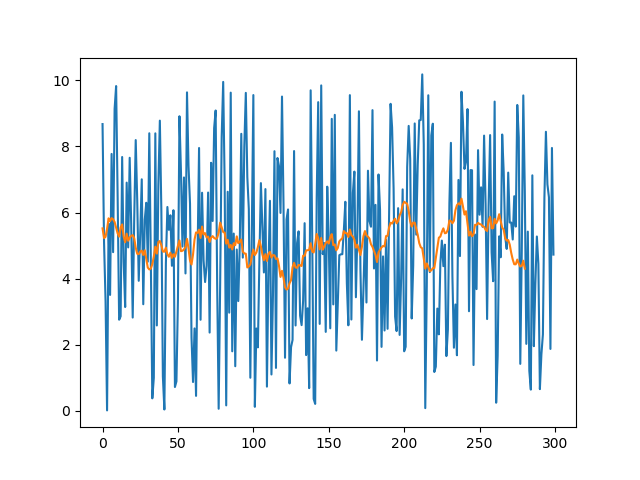

<IPython.core.display.Javascript object>


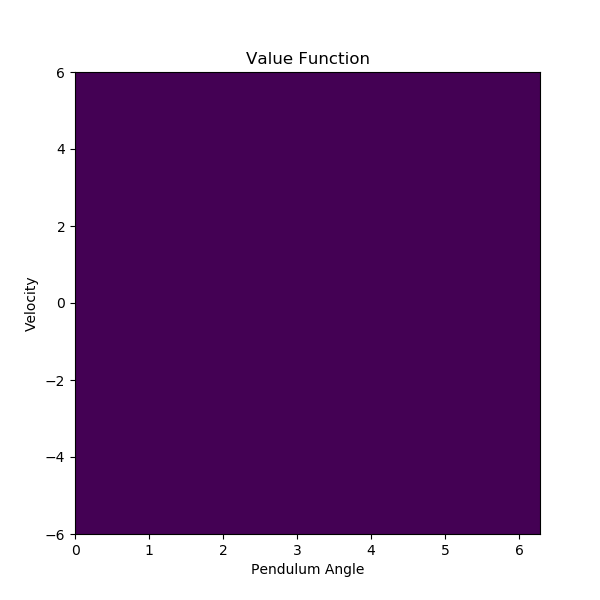

<IPython.core.display.Javascript object>


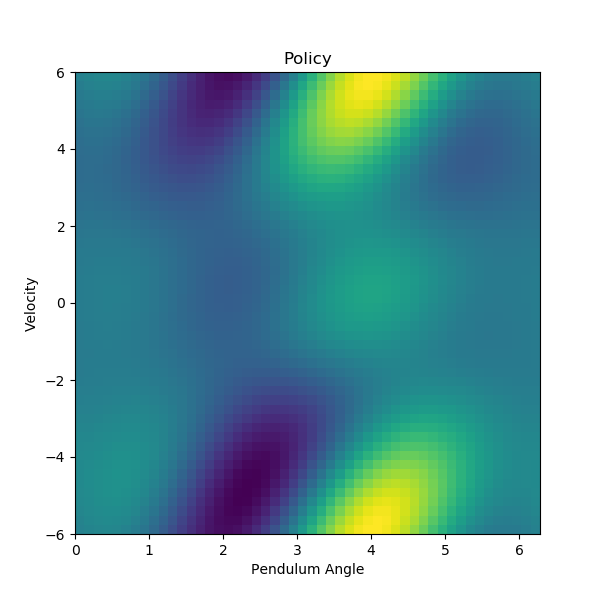

<IPython.core.display.Javascript object>


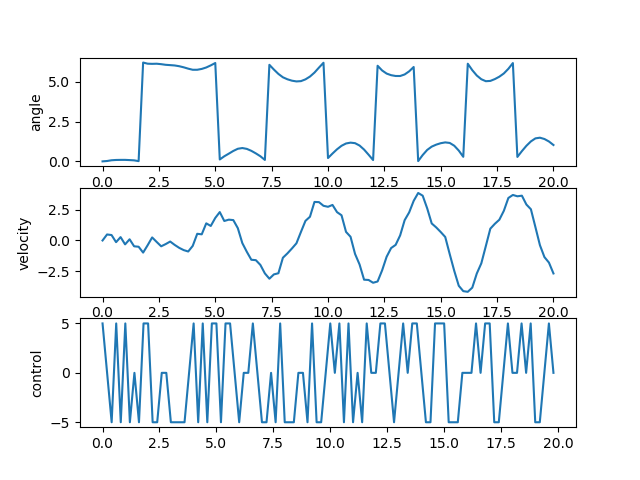

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAwtBtZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1OSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMTkgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADRlliIQAEP/+94G/Mstf
IrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsADpCLH/2+kONwAT9lg/NYj
L/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2fy1TN9QNLS2doYg16nA3K
BIICjrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17mhCeWbA7zyXROB8c1qwBw
G6mF4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr15+LI/6q7q3wu/lDZN9tIlT
OzRJ5hxurCa6TP3YdJ0Pua9/TkOnB1BZtIQdZE2NNeG6ZBWKX2qe8riq2xS9wgxfOhJNJt6YhrXM
m7zjVbb5XjgbkHcxnQGuWAediwJYqi3fm4ujHJ0imNhaD37uUGnV0uhFHwdHqWMHnkkZYv5dDA2w
u6b3OQ9KRwn5X82CXdBrwTfk3PfgmQi7fk9RABc2Y/lr+wk7/NGHIW6xbWrCQjWI3kMgmnZdCoBs
9vyRLBTpCVIj7av8Cn5DSXlEn/Sd+3NrATU5DNYJFIv98ZA73iur1uVp0nGsXxBFlJ1H2+4c5v0s
c6J3GHQJ+QWfXMMMpnrGfqYO8ABZaLotsFB/LHkbFwuip7F+yFSJmOPjnv2p6EsCzZ4ktjM8W1dX
aEG2suS0/qszjbFQY02+AIr2VapQc+1BFWqrc1pu17ohfTzwXn2fKAC521nnAAADASwwUcqaY5Ak
vpzqiYbgXMusVE5UI3xjdJZl9YGeFULlnFgp1TO5S2Liv14oliSHmEgBfyvgJUGY+viXF+3slMUU
NvjN43DbvlyPftQmotUoNmZ6iC0u8C3rP+UAlIc5XUS8OjIugA/9NoyVmDgnwL+uLGt/KnfzpEjI
TPNoHipGodbevjJXz30F6rCm8V5jAXpkfrIUfs1o8we/rTyZwr+tv43dX5mNUeujE0+iEYuqmioE
GKBVbAkHtr0X1XSkhwZCOlz/giHIo53YYHiTJ68i+oPIjy1vZV826tl3+IlEUVrOeA7/snV9L7Z5
dpSWygaLYg3xXP+f/44aNNyLRPmRM8xwrNgYuuFRbFKM3ctLfERfv6LG/Y2bbQWnZs3HxGi2FH1H
AyQL6XflhjC4Dh3Sxn5kIlFh39rUdLZ4Jmg1WKrKyv4Eqh/m5JfyhZTyy2FktQvYZJr163JZE8G1
xuVHr6PP2PPpwoXqe2KEjShYCjBycndPP2/tqz9vKOJknWTWXdYOwrYbM1SHkaU13luBzCHdd0Tl
0tGTJBsVRJbjFjLFjN0E1eB5qJ8rs1cUPANYgYznElsL0IDv3UzDpdghtGl8PAzCjFZG1aMS3+bN
q5256+3k/VE0Ub+L8CKiEolIA5viNmI/SZgf2x2Z6B1GhqFpTre42nQM4QfwMHye/keb+GcCzRHT
MUw1HWt1m1QJmUFYIw/8Lx3WO7Ew03jLey52DOlcf1AwQkTQa0Gpm6Hopsaqq+Ql42th+fcSWo3x
Rqko42/I+zrGntIFAgfsjQMCPI6t+bYPEGjw5Th62AGLBTbU6eezqnEmw1R5m22UA1zO6pNZuzvR
+Y/4MQDVKv8BsKVszjf23/pUh4oNx4b34YcDY/YzAeS6g3MJIinU8hCCBJcaJ9jhfNN415z7RB2s
N45AAJg+tdCq3zdY2gQR0qhZc0Ew/lDs0xjhIsGzGebW7XVM7oJHnDqB1EpoMlBZh5/MY3tq/x71
c1OufiiSjaGUlJGOCSex4iPU8dgZ2Z7HrdncTcPltxpG3NWuED8ZpDcsiZBIs9tt6MmzNbY6857x
grGWm9tC5K9hTMCSIKnRQMaOKRACzYopSSl3/tUbin34XqSQuD2lntfOgQnNNPNaD/+5dY5hJL9b
pblhXD32XYJk5sfLT61YTTNUxoCImfIKye0rrzWplYRfFbSJJxzLVLMHeQv7o16xWW6/XOm7laWk
F009G55O+yII8CDS++9Jm21sc0JBehunA62oJhX4/WmtOISvwbXLEC5c0j14Jhj1+SHNIEHBVA4c
MOnOqpsNbUxkkBRRYLRF9KusUZdx4KTlJHcB269KrVkbjiFMY+u+9nKQvLdzpYKIminQQDJJLyJH
2h8ns6dv1134hTXGw2WcId9ugA2AS8x2Agx4eBwOJGGjNNSYmDSr44i6VDZOM6ghdgxwQR6sVEDq
SLcw3mShT6DTIB9/+ZBv9WiIwcdUfslrC8JYNbFye55xz8O2kzrt9Lqq+gLb/CzdaealalS46j+G
oENsxLs7JgHrFi0QZmdp9KbrbTeYdtdjPCo7+7lWNiNk81raILGu52XMZi98zLYkDa2pvbAPCHRw
VyxLDRv5n70C1tp5HWNwx+u3b1OHB7HlKwAAPAlE+N8AUw7bEiPEEwDkTUl3moUm4K61ebHk6Vd7
q1kqsGVkf1xxEmOANCbupMBOI4+57G4NhEEUygxmNpYWSimPU8b8T5WnSsgZkwDliPGFSy5d+Nbt
sv+X2sV6J5bjfLZtqahQgjhPlwZo1T4lXbsmZUjyyaUrxjz354PW1KzJTS3is+2SYp/Esf3KnTpd
dfiWzp+iqdyIbAeIYbSv+fdtHDOkCd/f3KfzvuYB+KJLTltuE9Nhz83NWfcHb5xJlKbUV0dslWUA
/Tu080GrushgmYdyNtpuK5kZWzQ19nRtWG2FttsC489yQgQSFh6mNeZscxDxG3qMudNYQXhbjivN
+SdBHYPU3nyg54TCRUyYPk0Q5Fv/9/FBNjs6+8rny1AYAadMmkMKfwq0NedVSJA27JJGvuoz5VZi
k7hDQKN5ef/q6XwELp8K8IczO6MP/WsQJ0GcDhYTS/yKfLWAC2B6mJ3oVZ4hiUVZL2T5emgiaUIX
lZHbo9z2rCvP7wXJQYCcK

In [39]:
# here we learn doing 300 episodes
lear = reinforce.iterate(1500) #you will likely need more than 300 episodes!

# we plot the learning progress - also including a moving average (over 20 data points)
plt.figure()
plt.plot(lear)
ret = np.cumsum(lear)
win_avg = 20
ret[win_avg:] = ret[win_avg:] - ret[:-win_avg]
plt.plot(ret[win_avg - 1:] / win_avg)

# we get the policy/value as arrays
pol, val = reinforce.get_Policy()
# we create a controller using the policy to be used in the simulation
control_policy = lambda x : reinforce.policy.sample(x)[1]
# we plot results including a 10s simulation of the pendulum using the policy
plot_results(pendulum, val, pol, control_policy, animate=True)

In [43]:
# Part D
class Reinforce_baseline:
    """
    An implementation of the reinforce algorithm (with or without baseline)
    """
    
    def __init__(self, model, cost, policy,value, discount_factor=0.99, 
                 episode_length=100, policy_learning_rate = 0.000001,value_learning_rate=0.001):
        """
        the class constructor
        """
        self.model = model
        self.cost = cost
        self.value = value
        self.policy = policy
        self.value_learning_rate = value_learning_rate
        self.discount_factor = discount_factor
        self.episode_length = episode_length
        
        self.policy_learning_rate = policy_learning_rate
            
    def iterate(self, num_iter=1):          
        """
        the main loop
        """
        learning_progress = []
        
        # here we allocate some useful vectors
        x_traj = np.zeros([self.episode_length+1, self.model.num_states])
        u_traj = np.zeros([self.episode_length, 1])
        u_index = np.zeros([self.episode_length], dtype=np.int)
        cost_traj = np.zeros([self.episode_length])
        
        for i in range(num_iter):  

            x_traj[0,:] = np.zeros([2])
            for k in range(self.episode_length):
                u_index[k],u_traj[k] = self.policy.sample(x_traj[k,:])
                x_traj[k+1,:] = self.model.step(x_traj[k,:],u_traj[k]).transpose()
            for j in range(self.episode_length):
                G_t = 0
                for k in range(j,self.episode_length):
                    G_t = G_t + (self.discount_factor**(k-j))*cost(x_traj[k,:],u_traj[k])
                d = G_t - self.value.getValue(x_traj[j,:])[0]
                self.value.theta = self.value.theta + self.value_learning_rate*(self.discount_factor**j)*d*gardient_v(self.value.getValue(x_traj[j,:])[1])
                prob_dist,func = self.policy.get_distribution(x_traj[j,:])
                self.policy.theta =  self.policy.theta - self.policy_learning_rate*(self.discount_factor**j)*d*gradient_p(u_index[j],prob_dist,func)
            learning_progress.append(G_t)
        return learning_progress
            
    def get_Policy(self):
        """
        This helper function generate a 50x50 grid (theta x omega) with a policy (for display)
        the policy is computed as the expected control from pi
        we also compute a value function (to be used for the baseline part) - for now it is 0
        """
        n_discrete = 50
        pol = np.zeros([n_discrete,n_discrete])
        val = np.zeros([n_discrete,n_discrete])
        x_range = np.linspace(self.model.state_range[0,0], self.model.state_range[0,1], n_discrete)
        v_range = np.linspace(self.model.state_range[1,0], self.model.state_range[1,1], n_discrete)
        
        for i, x in enumerate(x_range):
            for j,v in enumerate(v_range):
                dist, basis = self.policy.get_distribution(np.array([x,v]))
                pol[i,j] = dist.dot(self.model.controls)
                # this can be used later to get a value estimate
                val[i,j] = self.value.getValue(np.array([x,v]))[0] 
        return pol, val

def cost(x,u):
    """
    the cost function for the inverted pendulum
    """
    return (x[0] - np.pi)**2 + 0.01*x[1]**2 + 0.0001*u

In [54]:
# here we create all the objects
pendulum = Pendulum()
policy = StochasticPolicyPeriodicFeatures(controls = pendulum.controls, order = 2)
value = ValueFunctionPeriodicFeatures(order = 2)
reinforce_b = Reinforce_baseline(pendulum, cost, policy,value, episode_length=100, 
                      discount_factor=0.99, policy_learning_rate = 1e-7, value_learning_rate = 1e-2)

<IPython.core.display.Javascript object>


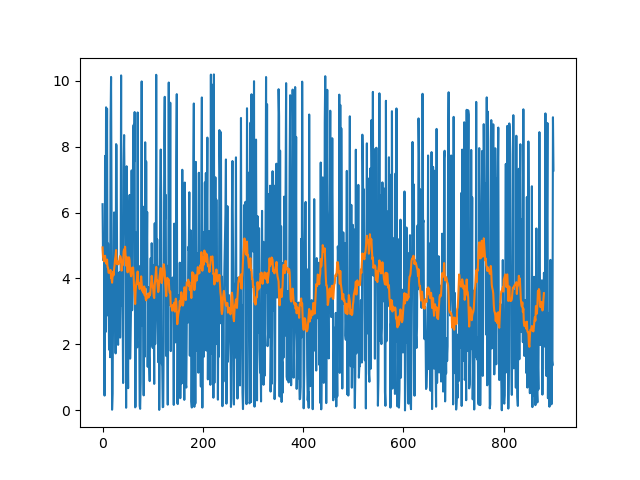

<IPython.core.display.Javascript object>


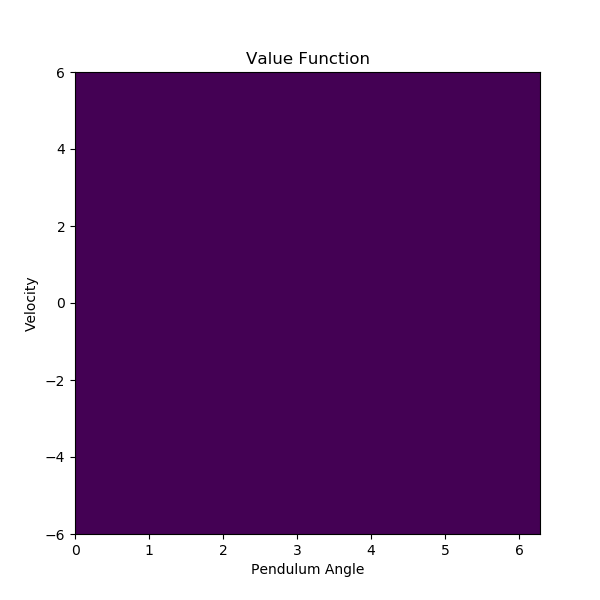

<IPython.core.display.Javascript object>


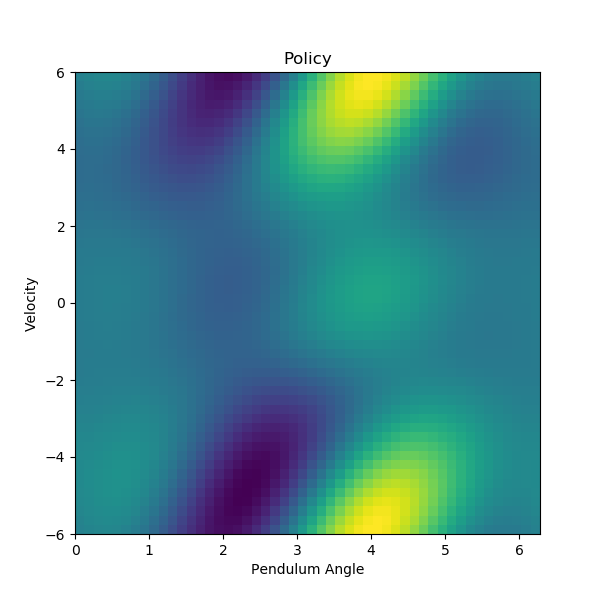

<IPython.core.display.Javascript object>


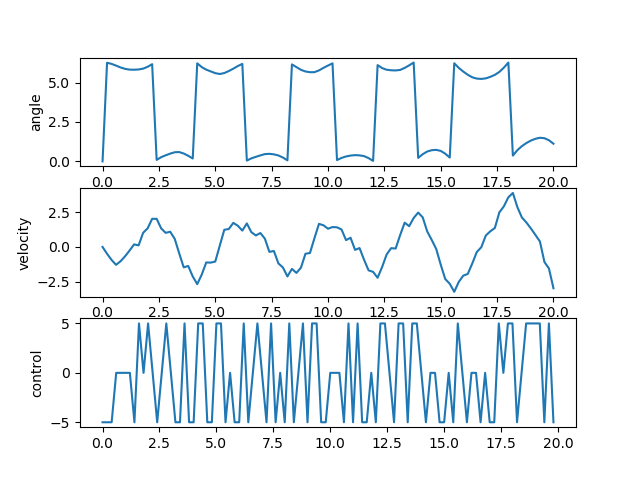

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAvUdtZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1OSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMTkgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADQlliIQAP//+92ifApta
Q3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACyBmSZ6XFJE4APMMeydN00
/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/lqmb6oagJo7SFBr1OBuUC
QQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2VvBtnz7czyXRN90c1rKBwG
6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcKL8eOssBoMcX7PXzJUsrb
PviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFVtil7hBi79CSaTb0xDWuZ
N3nDq23yvHA3INZjOgNcsA87FgS7RxahBxc+OmniIFYF+j3coOCrpdCKPg6PUsYPPJIyvfy6GBth
d1X3VUGikZO58pJ6STZmQo61urgqv/Mz2++KiAC5sx/LX9hIP+Jz5nrKxbXWaoRrDbx+QTTsuhUA
2e33z9YU6HaQ/iopLYQ5bZH9oDdnsb55tYCanIZrBIo4/vjG7G8VvmrUeUbwMfc7oEWDcg2+4c5v
0sc6J3GG3IncK0XM0MpnrGfqYO8ABZaLpfl07/Azf72gfzhGdnJe9UFlPHPftj0JYFmzxJbGZ4tq
5W0IMJZcaZ+qytfjqtBYwHi72VisArAxm6LNW57pSdE8d6YFZ0aeRuoAAAMAIPQA1xDjT8erT4L8
hUHsToTz/SHFFFy+MbpLMxpj3q8RhbVerbmyZycsIguFmSYkh5hIAZ6QLIVBmNd4wh87F9hFFDb4
zeNw675cj37UJqLVMDZmeogtLvAt6z/k+8+HOV1EvDoyLoAX/TaMlZg4J8C/riyrfyp386RIyEzz
aF4qRqHW3r4yV899heqwpvFeYwF+ZH6yFH7NaPMHv618mcK/rb+N3V+ZjU6rxsns4VcKKEwvwl0o
ZLMdOtBlzNmST+OiHFgH/zF0hTgMoMDxJk7+RfRhkR5ltgPoa3EV9/iJRFFazngO/7J1fS+2efaU
lsoGi2IN8Vz/n/+OGjTci0T5kZGCbaDBkbnuRaEH/U9XFviIv39FjfsbN9oLTs2bj4jRbCj6jeVO
vMTIbB0CLGh3Sxn5kIlFh39rUdLZ4Jmg1WKrKzv4EqiA+JqSHAHzMR2/+roFHAVK/y/wiBaDEImn
0I7YC9Q7j09UMVPbFCRpQsBRg5OTunn7gWtMOwlHEyTrJrLusHYVsNmao/gTcB3luBzCHdd0Tl0t
GTJBsVRJbjFicboEx3sIWQRYNgucjQIgWsQMZziS2F6ED37qZh0uwQ2jS+HgZhRisjatGJb/Nm1U
5qD77iSJJeiUtWPBfZG3lJ8boiiOx3gWAv49fF/02Dbw3dTre4cFQN4QfwMHye/keb+GcCzRHTM0
w1HWt1m1QJmUFYIw/8Lxtv6z8w03jLey52DOlcf1AwQkTQa0Gpm6HupsaTLchLxtbT8+4ktRvijV
JRxt9atDUle0fspW3imTVs+vhYHJamiGzwhOHrYAPgVZ3GU8R1DIkyuWBZNgrXsjM7qk1y7O9H5j
/gxANUq/wGwpWzON/bf+lSHig3HhvfhhwNj9jMBxLqDcwkiKdTyEIIElxon2OF803jXnPtEHaw3j
kAAk0D04mW+rqA+gjvjbnROlBMrhEV/EOQ59H4ITb6nVYdsLLVr0noB2JtLbqBDfzEpk57JiC5Jd
kfXtuaDQAee5Ar+K0oYzGI3NNrj4tWFXRz0p2eJdwzxHNTjp0BR0p1wv7AN6PQOtXhvPc/7qi0ie
Ku7b7IWX32SrAS7sanmWVh8Y29FLf/T43FPvazMkYTBmsu79pmmSAmZvg/XKe8Y5Z/DZS5V+n3T7
abUFd6qlGPOw6CCuE/td51n8YmylZL4Id1N9mBDyHXzyrQ+mMC8vEfm+mna7HA/naRK0tILpp6Nz
1o9/SVQSnMI1Fe9hVOEgvML22fwGnK4PO/2Llyyo5AZ0pjlRuzi1kBLenZ+ClwOV/bRbnCNU/C6a
shkxLamCw1+2SOjhLtAFgqzfReJu3TYq22/Ahoc8lkk/pn9nx2jLstm/2LCJgGrOvuyrwuesaAX8
1ThMctiszCjkSBGvOtJYuvZlv2gbbwPw8yI+bnXGuMMCiXVSeA0Ka5KY9Wgi8DpJOSkCOD2acsXd
ys/Gf/5Obais4iKsukp3brPHb4UlqzQejRRCvQMfegs5sbxO0cCkic/IL8tJaybBpvMxOzim35dX
qaIH0V2z5bk6QFp4c08mA/deExRrxcAAACO1BSdBpHwMe1O25I+gNZ5RZopHrCI0wSbQsM9mn6iB
7HK9lTLXZU64YZ2wAAA+C4APO7zfa4qluKXVKlRXTvP5sk9+uMu7VVEvCYz8Fb6AU49xzj6nNv5f
/as7sblIC/ZwtGeC+lSh5Y6T5ABquybgqz/Xq2qhcKp58VPHDEH3jnVQtSpJO1XkDWzXEDIlN4SH
/aF46cnf1cxpTW7Lkeuj9vzn9R7r48JZtPrOkwhk2jMrh5+Q49dXH9yp2Uijnl5lM69fNgdA7CaF
qKVhkVU6bb/n8yATvkN1wHNUee7f37r7Zymx7JuTKm98nRrgP29gu+TsT3YfrLaeaDV3WQwTQ6KY
LTsnTPRKtweQ+yvS3Rtq2wLjz3JCBBIBBglD3C+wdVojmlmL5qW6mu2btacG0s73SgCQRPKJdWEi
pkwfJohyTr/6MWhish5zYa8B6DRPBSuW6/RbqlaYi+NNcwnrMWB14m06xgztJ6nIZjWcr3/5QGu1
9F6Jlyo5EbRWZjCCfcS6ToSvqto+mmUdzvjuh+Oz98TLEh3Yw7fl51Q999D+KQo6pgcx6/x/PKe4
Li0Y1Yw8jSSPaTMDWd38N

In [56]:
# here we learn doing 300 episodes
lear = reinforce_b.iterate(1000) #you will likely need more than 300 episodes!

# we plot the learning progress - also including a moving average (over 20 data points)
plt.figure()
plt.plot(lear)
ret = np.cumsum(lear)
win_avg = 20
ret[win_avg:] = ret[win_avg:] - ret[:-win_avg]
plt.plot(ret[win_avg - 1:] / win_avg)

# we get the policy/value as arrays
pol, val = reinforce.get_Policy()
# we create a controller using the policy to be used in the simulation
control_policy = lambda x : reinforce.policy.sample(x)[1]
# we plot results including a 10s simulation of the pendulum using the policy
plot_results(pendulum, val, pol, control_policy, animate=True)